# Předzpracování dat a binární klasifikace

## Zdroj dat

Budeme se zabývat predikcí přežití pasažérů Titaniku.
K dispozici máme trénovací data v souboru **data.csv**.

#### Seznam příznaků:
* survived - zda přežil, 0 = Ne, 1 = Ano, **vysvětlovaná proměnná**
* pclass - Třída lodního lístku, 1 = první, 2 = druhá, 3 = třetí
* name - jméno
* sex - pohlaví
* age - věk v letech
* sibsp	- počet sourozenců / manželů, manželek na palubě
* parch - počet rodičů / dětí na palubě
* ticket - číslo lodního lístku
* fare - cena lodního lístku
* cabin	- číslo kajuty
* embarked	- místo nalodění, C = Cherbourg, Q = Queenstown, S = Southampton
* home.dest - Bydliště/Cíl

# Zpracování úkolu

In [1]:
import time as t
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Základní analýza a vizualizace dat
- zde vypisuji základní info o datech
- co hledat:
    - počet záznamů a příznaků
    - jaké příznaky je nutné konvertovat na kategorická data
    - null hondoty
    - počet unikátních hodnot každého příznaku

In [2]:
data = pd.read_csv('data.csv')

# replace empty values with np.nan
data = data.fillna(np.nan)

print(data.info())

print('Number of unique values')
display(data.nunique())

print('Number of null values')
display(data.isnull().sum())

display(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779 entries, 0 to 778
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         779 non-null    int64  
 1   survived   779 non-null    int64  
 2   pclass     779 non-null    int64  
 3   name       779 non-null    object 
 4   sex        779 non-null    object 
 5   age        623 non-null    float64
 6   sibsp      779 non-null    int64  
 7   parch      779 non-null    int64  
 8   ticket     779 non-null    object 
 9   fare       778 non-null    float64
 10  cabin      177 non-null    object 
 11  embarked   778 non-null    object 
 12  home.dest  457 non-null    object 
dtypes: float64(2), int64(5), object(6)
memory usage: 79.2+ KB
None
Number of unique values


ID           779
survived       2
pclass         3
name         778
sex            2
age           89
sibsp          7
parch          7
ticket       610
fare         227
cabin        136
embarked       3
home.dest    267
dtype: int64

Number of null values


ID             0
survived       0
pclass         0
name           0
sex            0
age          156
sibsp          0
parch          0
ticket         0
fare           1
cabin        602
embarked       1
home.dest    322
dtype: int64

,ID,survived,pclass,age,sibsp,parch,fare
count,779.000000,779.000000,779.000000,623.000000,779.000000,779.000000,778.000000
mean,389.000000,0.403081,2.277279,30.323301,0.486521,0.392811,33.914198
std,225.022221,0.490832,0.840880,14.279336,0.983546,0.906843,54.655205
min,0.000000,0.000000,1.000000,0.166700,0.000000,0.000000,0.000000
25%,194.500000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,389.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.750000
75%,583.500000,1.000000,3.000000,39.000000,1.000000,0.000000,31.275000
max,778.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


Z vypsaných informací vidíme, že musíme primárně vyřešit přetypování na kategorická data a konverzi / smazání řádků, které obsahují null hodnoty.

### Korelace numerických hodnot
- cílem je zjistit korelaci ostraních numerických příznaků s šancí na přežití

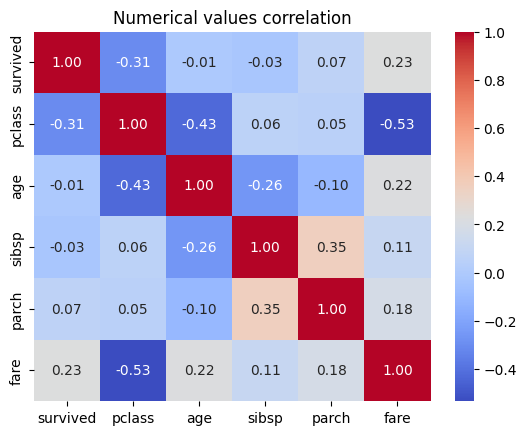

In [3]:
# select numerical data without ID
numerics = ['int64', 'float64']
data_num = data.select_dtypes(include=numerics)
data_num = data_num.drop(['ID'], axis=1)

# numerical data heatmap
sns.heatmap(data_num.corr(), annot=True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Numerical values correlation')
plt.show()

Z heatmapy vidíme, že by se šance přežití mohla odvíjet od příznaku `fare`.
Také spolu vysoce korelují příznaky `sibsp` a `parch`. Zde můžeme zkoumat šanci přežití na základě velikosti rodiny.  

### Distribuce věku
- zde nás bude zajímat zobrazení málo frekventovaných hodnot a distribuce věku podle přežití

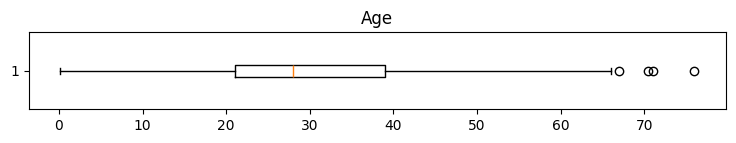

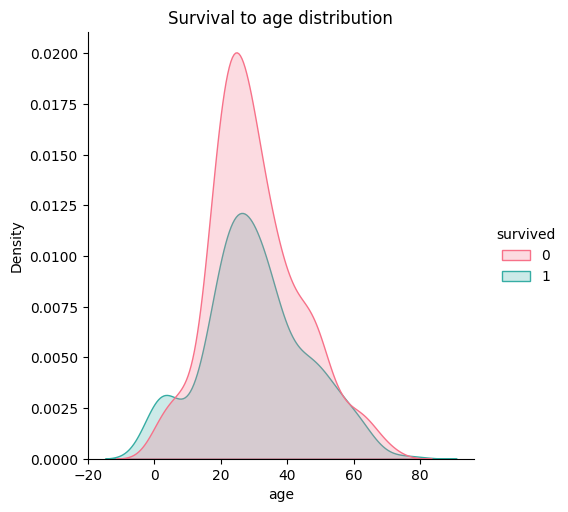

In [4]:
plt.figure(figsize=(9, 1))
plt.boxplot(data['age'].dropna(), vert=False)
plt.title('Age')
plt.show()

sns.displot(x="age", hue='survived', data=data, kind="kde", fill=True, palette='husl')
plt.title('Survival to age distribution')
plt.show()

Z boxplotu věku vidíme par odlehlých hodnot, které by mohli narušovat klasifikaci. Adekvátní by bylo buď odstranění nebo normalizace.
Graf distribuce přeziti ku věku nám ukazuje, že děti mohou mít lehce vyšší šanci na přežití.

### Rozdělení pohlaví
- vizualizace rozdělení pohlaví a závislot přežití na pohlaví

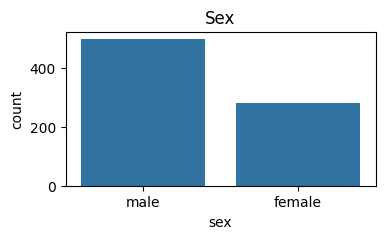

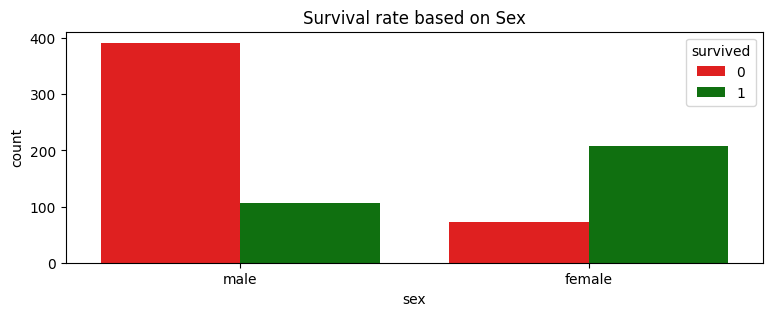

In [5]:
# sex distribution
plt.figure(figsize=(4,2))
sns.countplot(x = data['sex'])
plt.title('Sex')
plt.show()

# survival rate based on sex
plt.figure(figsize=(9, 3))
sns.countplot(x = 'sex', hue='survived', data=data, palette=['red',"green"])
plt.title('Survival rate based on Sex')
plt.show()


Z grafů je vidět, že ženy mají vyšší šanci přežít než muži.

### Místo nalodění
- zde opět budeme koukat na závislost místa nalodění s přežitím

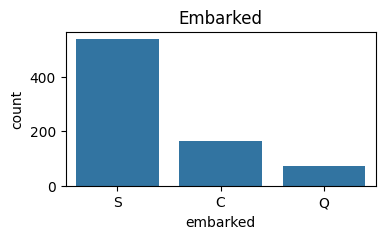

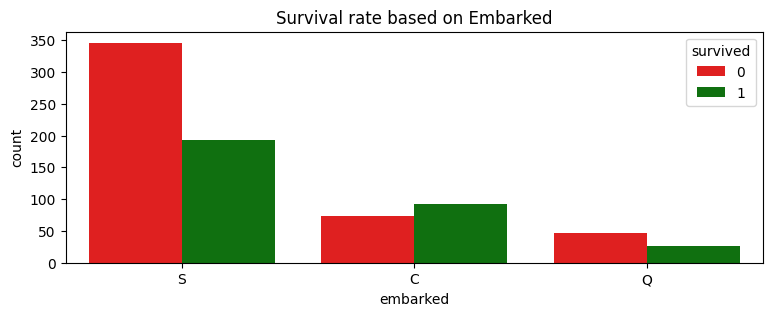

In [6]:
# embarked distribution
plt.figure(figsize=(4,2))
sns.countplot(x = data['embarked'])
plt.title('Embarked')
plt.show()

# survival rate based on embarked
plt.figure(figsize=(9, 3))
sns.countplot(x = 'embarked', hue='survived', data=data, palette=['red',"green"])
plt.title('Survival rate based on Embarked')
plt.show()

Zde vidíme, že lidé z Cherbourgu by mohli mít lehce větší šanci na přežití, než ostatní.

### Další příznaky (pclass, sibsp, parch)
- zde pouze vykreslíme rozdělení přežití pro každý z příznaků

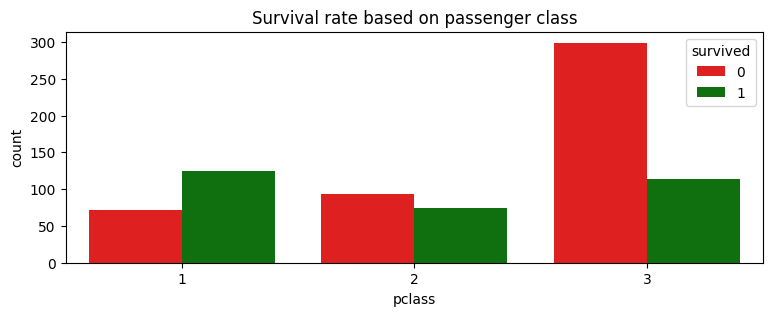

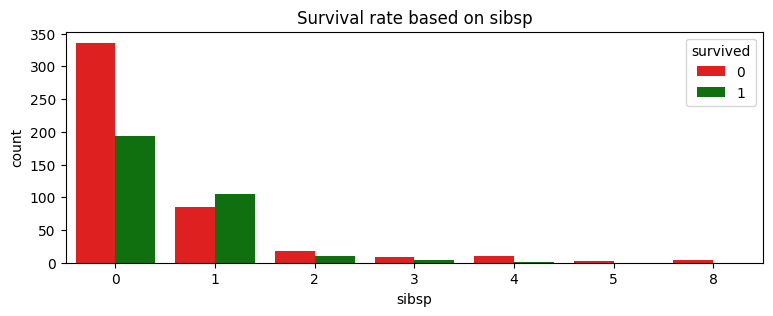

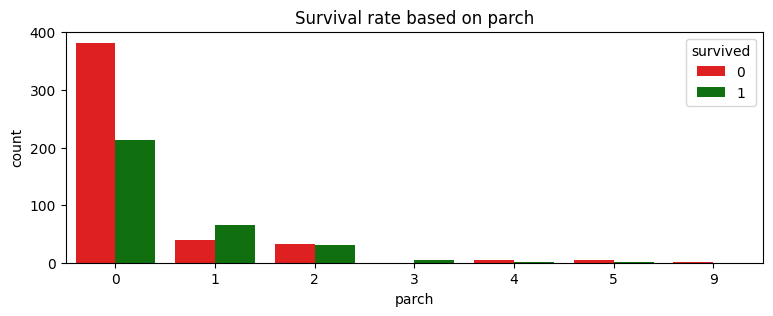

In [7]:
# survival rate based on class
plt.figure(figsize=(9, 3))
sns.countplot(x = 'pclass', hue='survived', data=data, palette=['red',"green"])
plt.title('Survival rate based on passenger class')
plt.show()

# survival rate based parch
plt.figure(figsize=(9, 3))
sns.countplot(x = 'sibsp', hue='survived', data=data, palette=['red',"green"])
plt.title('Survival rate based on sibsp')
plt.show()

# survival rate based sibsp
plt.figure(figsize=(9, 3))
sns.countplot(x = 'parch', hue='survived', data=data, palette=['red',"green"])
plt.title('Survival rate based on parch')
plt.show()

- Příznak `pclass` by mohl ovlivňovat šanci na přežití u lidí s lepší třídou.
- Z dvou grafů pro příznaky `sibsp` a `parch` vidíme, že většina lidí neměla na lodi žádné příbuzné. Naopak u těch co měli u těchto přízbnaků hodnotu `1`, tak vidíme vyšší šanci na přežití. *Matky s dítětem?* Větší rodiny spíše nepřežily.

## Zpracování dat
- nějakým způsobem se budu snažit vyextrahovat užitečné informace ze všech nenumerických příznaků a převést je na co nejmín unikátních kategorických hodnot

In [8]:
# convert sex and embarked to categorical data
data[['sex', 'embarked']] = data[['sex', 'embarked']].astype('category')

### Extrahování titulů ze jmen
- jelikož jméno má 999/1000 unikátních hodnot, tak je v tomto případě bráno jako spojitá hodnota. Idealní by byla konverze na nominalní kategorickou hodnotu

In [9]:
def extract_titles(df) -> None:
    """ Extract titles from names """

    # parse titles from names
    titles = [x.split(',')[1].split('.')[0][1:] for x in df['name']]

    # add into dataframe
    df['titles'] = pd.Series(titles).astype('category')

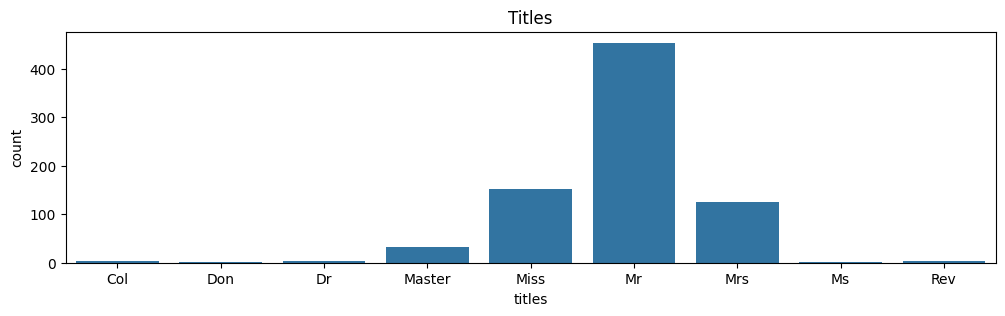

In [10]:
extract_titles(data)

plt.figure(figsize=(12,3))
sns.countplot(x = data['titles'])
plt.title('Titles')
plt.show()

Z grafu vidíme četnosti titulu. Jsou zde ovšem obsazeny málo frekventované tituly. Ty by bylo vhodné zastřešit pod jednu kategorii.

In [11]:
def replace_nonfreq_titles(df) -> None:
    """ Replace not frequent titles with `other` """

    other = ['Col', 'Don', 'Rev', 'Dr', 'Ms', 'Major', 'Capt', 'Jonkheer', 'Mlle', 'Lady', 'Mme']
    df['titles'] = df['titles'].replace(other, 'Other')

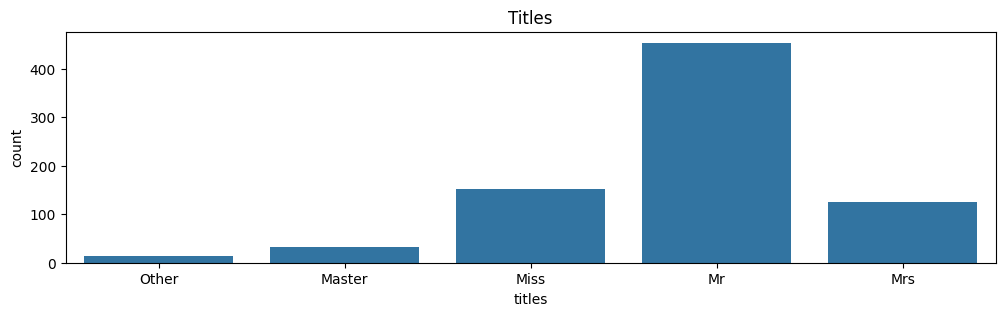

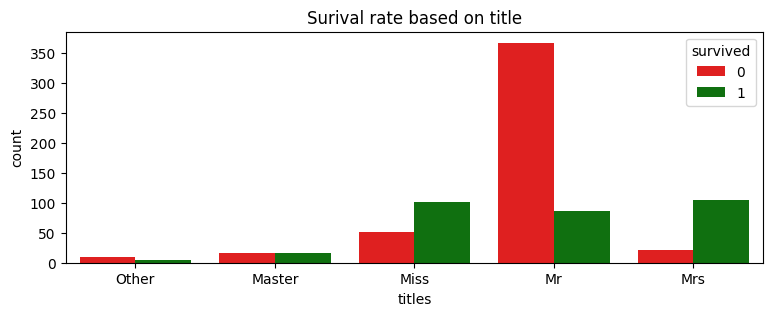

In [12]:
replace_nonfreq_titles(data)

# title frequency
plt.figure(figsize=(12,3))
sns.countplot(x = data['titles'])
plt.title('Titles')
plt.show()

# title graphical corr with survived
plt.figure(figsize=(9, 3))
sns.countplot(x = 'titles', hue='survived', data=data, palette=['red',"green"])
plt.title('Surival rate based on title')
plt.show()

Po agegaci máme 5 kategorii pro titul ze jména.
Z grafu následně vidíme, že nejčetnějším titulem je `Mr` s malou šancí na přežití. Naopak u hodnot `Miss` a `Mrs` vidíme častejší přežití.

Tento fakt už jsme si ověřili při zkoumání závislosti přežití na pohlaví.

### Vyplnění null hodnot věku
- vzhledem k velkému počtu chybějících hodnot věku budou null hodnoty vyplněny střední hodnotou věku, kterou maji záznamy se stejnou hodnotou ve sloupci `sibsp`, `parch`, `pclass`, `title`

In [13]:
def replace_by_index(df, column: str, idx: int, value) -> None:
    """ Replace single value in dataframe based on index and column"""
    series = pd.Series(df[column])
    series[idx] = value
    df[column] = series

In [14]:
def fill_null_ages(df) -> None:
    """ Fill null ages in dataframe with age of similar values """

    # get null age values indexes 
    null_age_indexes = list(df['age'][df['age'].isnull()].index)
    age_median = df['age'].median()
    similar_df = pd.DataFrame()


    for i in null_age_indexes:

        # create dataframes with same values in columns
        sibsp_df = (df['sibsp'] == df.iloc[i]['sibsp'])
        parch_df = (df['parch'] == df.iloc[i]['parch'])
        pclass_df = (df['pclass'] == df.iloc[i]['pclass'])
        titles_df = (df['titles'] == df.iloc[i]['titles'])

        # get median from all collected similar data
        similar_df = (sibsp_df & parch_df & pclass_df & titles_df)
        predicted_median = df[similar_df]['age'].dropna().median()

        if not np.isnan(predicted_median):
            replace_by_index(df, 'age', i, predicted_median)
        else:
            replace_by_index(df, 'age', i, age_median)

In [15]:
fill_null_ages(data)

### Vyplnění null hodnot jízdného a místa nalodění
- vzhledem k tomu, že u obou příznaků chybí pouze jedna hodnota, tak dojde k nahrazení null hodnoty nejčetnější hodnotou

In [16]:
null_embarked_index = list(data[data['embarked'].isnull()].index)[0]
null_fare_index = list(data[data['fare'].isnull()].index)[0]

fare_median = data['fare'].median()

display(data['embarked'].value_counts())
display(fare_median)

embarked
S    539
C    166
Q     73
Name: count, dtype: int64

14.75

In [17]:
# replace embarked null value
embarked = pd.Series(data['embarked'])
embarked[null_embarked_index] = 'S'
data['embarked'] = embarked

# replace fare null value
fare = pd.Series(data['fare'])
fare[null_fare_index] = fare_median
data['fare'] = fare

### Číslo kajuty
- Kajuty jsou ve tvaru prefix a číslo. Čili nás bude zajímat pouze prefix kajuty a null hodnoty budou nahrazeny znakem `N`
- takto bude možné kajuty kategorizovat na nominální hodnoty

In [18]:
def parse_cabins(df) -> None:
    """ replace missing cabins with None and parse cabin deck """

    cabins = pd.Series([str(x)[0] if x is not np.nan else 'N' for x in df['cabin']])
    df['cabin'] = cabins.astype('category')

['n', 'C', 'D', 'B', 'E', 'A', 'F', 'T', 'G']
Categories (9, object): ['A', 'B', 'C', 'D', ..., 'F', 'G', 'T', 'n']

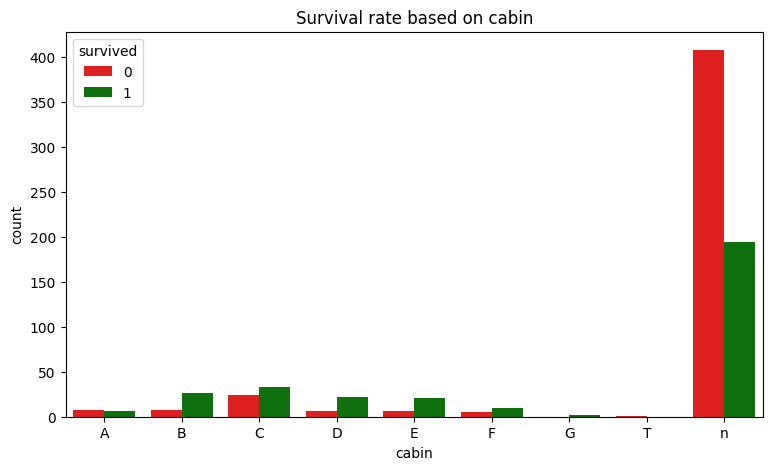

In [19]:
parse_cabins(data)

display(data['cabin'].unique())

# survival rate based on cabin
plt.figure(figsize=(9, 5))
sns.countplot(x = 'cabin', hue='survived', data=data, palette=['red',"green"])
plt.title('Survival rate based on cabin')
plt.show()

O lidech bez kabiny toho nemůžeme moc vyvodit. Ovšem u lidí z kabin `B`, `C`, `D`, `E` předpokládám větší šanci na přežití.

### Ticket
- vytřídění jízdenek na pouze nečíselné hodnoty a následná konverze na kategorie

In [20]:
def parse_tickets(df) -> None:
    """ Parse tickets by prefix """

    # parse prefixes and replace nonnumerical tickets with 'N'
    tickets = pd.Series(['N' if x.isnumeric() else x.split()[0] for x in df['ticket']])
    tickets = tickets.str.replace('.', '', regex=True).str.replace('/', '', regex=True)

    # parse onto only 2 characters for less unique values
    tickets = pd.Series([(x[0] + x[1]) if len(x) > 2 else x for x in tickets])
    df['ticket.pref'] = tickets.astype('category')

In [21]:
parse_tickets(data)
display(data['ticket.pref'].unique())

['']
Categories (1, object): ['']

### Destinace
- Null hodnoty budou změněný na `NN`
- Lidé se známou cílovou destinací by mohli mít větší šanci na přežití

In [22]:
def parse_destination(df, treshold) -> None:
    """ Parse destination onto 2 unique chars with freq higher than treshold"""

    # parse home dest by 2 char names (NN == empty dest)
    dest = pd.Series([str(x).split()[-1] if x is not np.nan else 'NN' for x in df['home.dest']])
    dest = pd.Series([(x[0] + x[1]).upper() if len(x) > 2 else x for x in dest])

    # count values frequencies
    freq = {}
    for x in dest:
        if x in freq.keys():
            freq[x] += 1
        else:
            freq[x] = 1

    # remove rare values with NN
    dest = pd.Series(['NN' if freq[x] <= treshold else x for x in dest])
    df['dest'] = dest.astype('category')

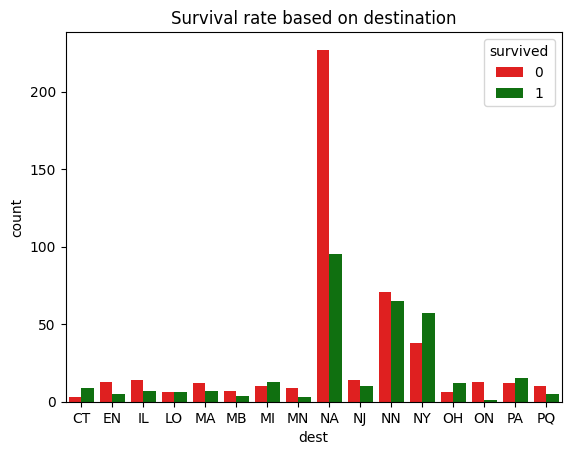

In [23]:
parse_destination(data, 10)

sns.countplot(x = 'dest', hue = 'survived',  data=data, palette=['red',"green"])
plt.title('Survival rate based on destination')
plt.show()

Z grafu vidíme, že u většiny lidí nevíme cílovou destinaci. Tam, kde ji ale známe, tak by mohla lehce ovlivňovat šanci na přežití. *Korelace s `fare` nebo `pclass`?*

## Trénování modelů a ladění hyperparametrů
- jelikož predikujeme binární hodnotu, tak mi jako vhodný model přijde `DecisionTreeClassifier`
- dále vyzkouším i `kNN`

In [24]:
# removed not useful columns
data = data.drop(['ID', 'name', 'ticket', 'home.dest'], axis=1)

data_num = data.copy()

# convert categorical data to numerical
cat_cols = data_num.select_dtypes('category').columns
data_num[cat_cols] = data_num[cat_cols].apply(lambda x: x.cat.codes, axis=0)

display(data_num.isnull().sum())

survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
cabin          0
embarked       0
titles         0
ticket.pref    0
dest           0
dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

seed = 420

Y = data_num['survived']
X = data_num.drop(['survived'], axis=1)

# split data onto train, val, test
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=seed)
Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size=0.25, random_state=seed)

display(Xtrain.shape)
display(Xval.shape)
display(Xtest.shape)

(467, 11)

(156, 11)

(156, 11)

### Decision tree classifier
- klasifikační strom budu ladit pro hyperparametry `criterion`, `splitter`, `max_depth` a další

In [26]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score

param_grid = {
    'criterion' : ['gini', 'entropy'],
    'splitter' : ['best', 'random'],
    'max_depth' : range(1, 10),
    'min_samples_leaf' : range(2, 5),
    'max_leaf_nodes' : range(5, 15)
}

param_comb = ParameterGrid(param_grid)
train_acc, val_acc = [], []

# estimate runtime
second_coef = 75
print(f'Est. time for {len(param_comb)} combinations: {len(param_comb) / second_coef} sec')

start_time = t.time()
for params in param_comb:
    tree_model = DecisionTreeClassifier(**params, random_state=seed)
    tree_model.fit(Xtrain, Ytrain)

    train_acc.append(accuracy_score(Ytrain, tree_model.predict(Xtrain)))
    val_acc.append(accuracy_score(Yval, tree_model.predict(Xval)))

print(f'Time: {t.time() - start_time} sec')

Est. time for 1080 combinations: 14.4 sec
Time: 4.560476779937744 sec


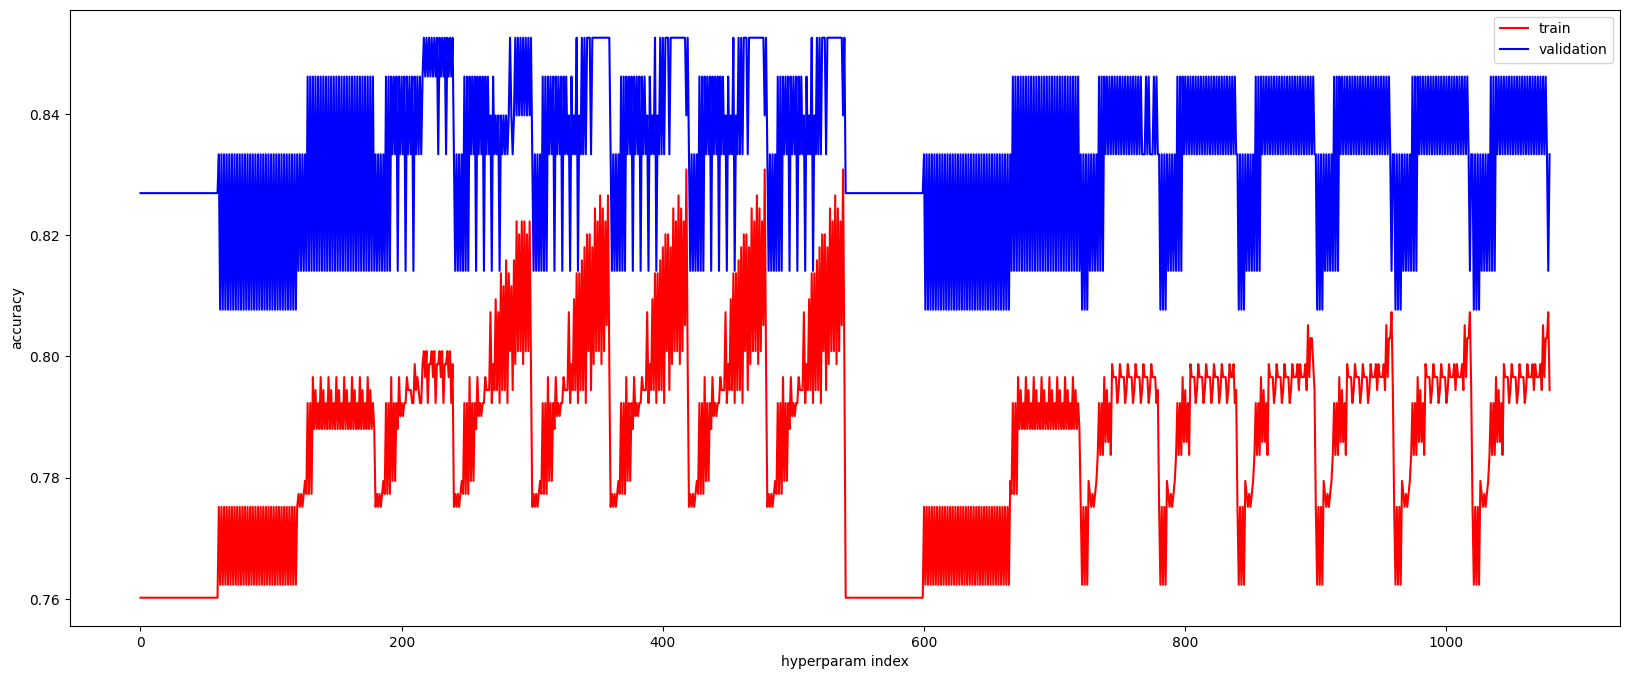

{'splitter': 'random',
 'min_samples_leaf': 2,
 'max_leaf_nodes': 11,
 'max_depth': 4,
 'criterion': 'gini'}

In [27]:
plt.figure(figsize=(20,8))
plt.plot(train_acc,'r-')
plt.plot(val_acc,'b-')
plt.xlabel('hyperparam index')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'])
plt.show()

best_params = param_comb[np.argmax(val_acc)]
display(best_params)

In [28]:
tree_model_best = DecisionTreeClassifier(**best_params)
tree_model_best.fit(Xtrain, Ytrain)

print('accuracy score (train): {0:.6f}'.format(accuracy_score(Ytrain, tree_model_best.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(accuracy_score(Yval, tree_model_best.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(accuracy_score(Ytest, tree_model_best.predict(Xtest))))

accuracy score (train): 0.802998
accuracy score (validation): 0.833333
accuracy score (test): 0.769231


### k Nearest Neighbors
- u tohoto je primární odladit hyperparametr `n_neighbors`

In [29]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    'n_neighbors' : range(1, 30),
    'weights' : ['uniform', 'distance'],
    'p' : range(1, 3)
}

param_comb = ParameterGrid(param_grid)

train_acc = []
val_acc = []

# estimate runtime
second_coef = 20
print(f'Est. time for {len(param_comb)} combinations: {len(param_comb) / second_coef} sec')

start_time = t.time()
for params in param_comb:
    neighbors_model = KNeighborsClassifier(**params)
    neighbors_model.fit(Xtrain, Ytrain)

    train_acc.append(accuracy_score(Ytrain, neighbors_model.predict(Xtrain)))
    val_acc.append(accuracy_score(Yval, neighbors_model.predict(Xval)))

print(f'Time: {t.time() - start_time} sec')

Est. time for 116 combinations: 5.8 sec
Time: 2.105668306350708 sec


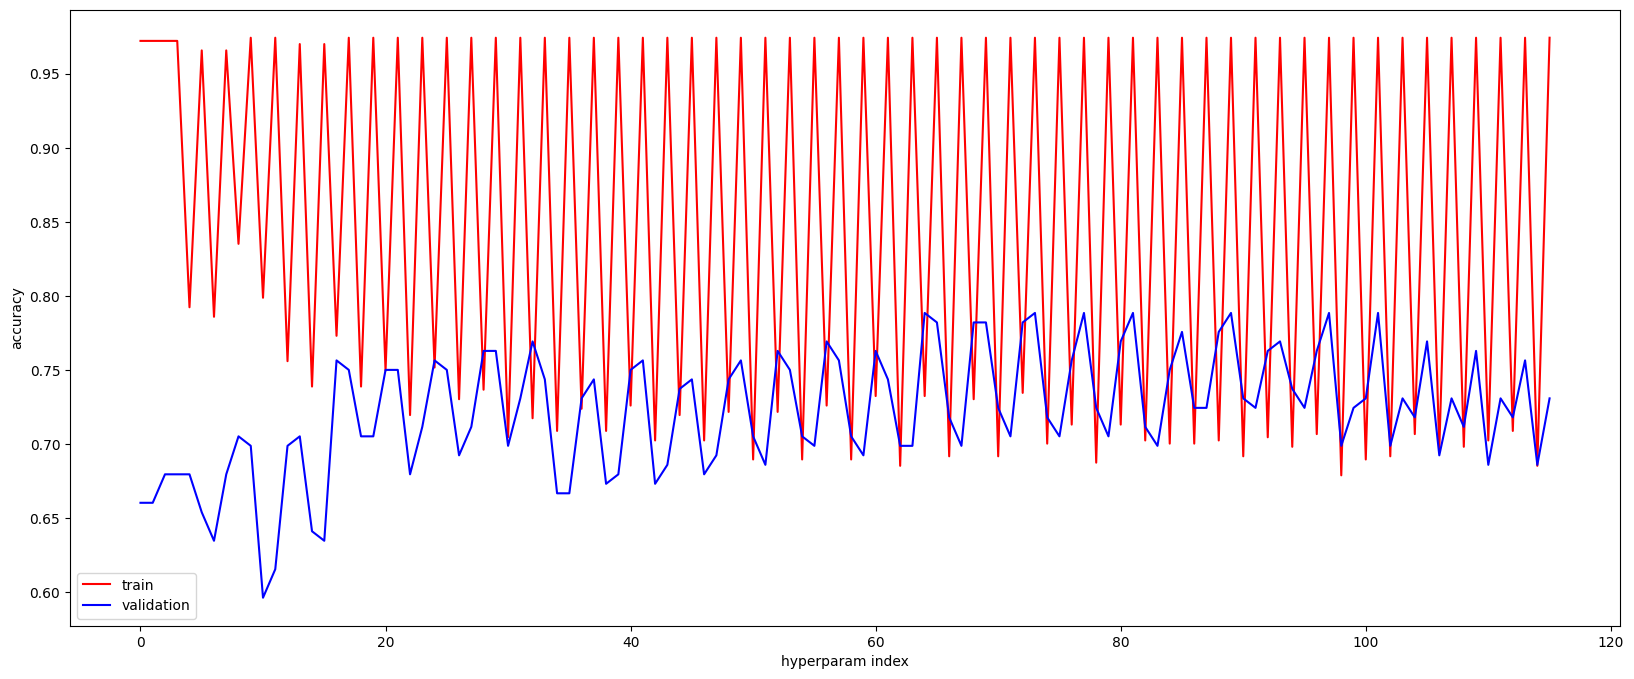

{'weights': 'uniform', 'p': 1, 'n_neighbors': 17}

In [30]:
plt.figure(figsize=(20,8))
plt.plot(train_acc,'r-')
plt.plot(val_acc,'b-')
plt.xlabel('hyperparam index')
plt.ylabel('accuracy')

plt.legend(['train', 'validation'])
plt.show()

best_params = param_comb[np.argmax(val_acc)]
display(best_params)

In [31]:
neighbors_model_best = KNeighborsClassifier(**best_params)
neighbors_model_best.fit(Xtrain, Ytrain)
print('accuracy score (train): {0:.6f}'.format(accuracy_score(Ytrain, neighbors_model_best.predict(Xtrain))))
print('accuracy score (validation): {0:.6f}'.format(accuracy_score(Yval, neighbors_model_best.predict(Xval))))
print('accuracy score (test): {0:.6f}'.format(accuracy_score(Ytest, neighbors_model_best.predict(Xtest))))

accuracy score (train): 0.732334
accuracy score (validation): 0.788462
accuracy score (test): 0.685897


### Vyhodnocení
- ze dvou použitých modelů nám lépe vychází klasifikační strom a to s validační přesností `0.83` a testovací přesností `0.85`
- vyberu tedy nejlepší hyperparametry pro klasifikační strom a natrénuji ho na trénovacích datech

In [32]:
params = {
    'splitter': 'best',
    'min_samples_leaf': 2,
    'max_leaf_nodes': 14,
    'max_depth': 5,
    'criterion': 'gini'
}

best_model = DecisionTreeClassifier(**params, random_state=seed)
best_model.fit(Xtrain, Ytrain)

print('accuracy score (test): {0:.6f}'.format(accuracy_score(Ytest, best_model.predict(Xtest))))

accuracy score (test): 0.769231
